#Main Fundermentle data pre-processing pipeline

In [251]:
import numpy as np
import pandas as pd
import itertools
import sklearn
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime,timedelta
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import  Pipeline
from sklearn.pipeline import FeatureUnion
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [252]:
daily_df = pd.read_csv('../../../data/main_data/DateDistric.csv')
info_df = pd.read_csv('../../../data/main_data/Info.csv')
district_dt_df = pd.read_csv('../../../data/main_data/EDA.csv')
police_df = pd.read_csv('../../../data/main_data/police_report.csv')

In [253]:
class DateEncoder(BaseEstimator,TransformerMixin):

    def __init__(self,col_name='Date',year='2020'):
        self.col_name = col_name
        self.year = year

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        x = X.copy()
        x['formal_date']= x.loc[:,'Date'].apply(lambda x: self.date_converter(x))
        x['quarter'] = x['formal_date'].dt.quarter
        x['date'] = x['formal_date'].dt.day
        x['day_of_week'] = x['formal_date'].dt.dayofweek
        x['month'] = x['formal_date'].dt.month
        return x


    def date_converter(self,x,year='2020'):
        dt = str(x).split('-')
        date = year+'/'+dt[0]+'/'+dt[1]
        date_obj = datetime.strptime(date,'%Y/%m/%d')
        return date_obj

In [254]:
class DatasetTuner(BaseEstimator,TransformerMixin):
    
    def __init__(self):
        self.col_order = ['index','formal_date','quarter','date','day_of_week','month','Suspected_Local','Suspected_Foreign','TotalInfected']
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        x = X.copy()
        x = x.rename(columns={'Unnamed: 0':'index'})
        x = x.drop(['ID', 'Date', 'District'],axis=1)
        #x = x.loc[:,self.col_order]
        return x

In [255]:
class WeatherTuner(BaseEstimator,TransformerMixin):

    def __init__(self):
        self.col_order = ['index','formal_date','quarter','date','day_of_week',
                          'month','Suspected_Local','Suspected_Foreign',
                          'temp','humidity','sun_hours','TotalInfected']
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        x = X.copy()
        x = x.merge(info_df, on=["month","index"])
        #x = x.loc[:,self.col_order]
        return x

In [256]:
tuning_pipe = Pipeline([
    ('date_adder',DateEncoder()),
    ('pre-tuner',DatasetTuner()),
    ('weather-tuner', WeatherTuner())
])

inter_res_1 = tuning_pipe.fit_transform(daily_df)

In [257]:
class ProvinceTuner(BaseEstimator,TransformerMixin):
    
    def __init__(self):
        self.province_dist_map = [1,1,1,2,2,2,3,3,4,4,4,5,5,6,6,6,7,7,8,8,9,9,9,9,9]
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        x = X.copy()
        x['province'] = x['index'].apply(lambda x: self.pr_ds_mapper(x))
        return x

    def pr_ds_mapper(self,x):
        return self.province_dist_map[int(x)-1]

In [258]:
class EDATuner(BaseEstimator,TransformerMixin):

    def __init__(self,col_name):
        self.col_name = col_name

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        x = X.copy()
        x['eda']  = x['index'].map(district_dt_df['EDA'])
        return x

In [259]:
class NeighbourTuner(BaseEstimator,TransformerMixin):

    def __init__(self):
        self.srr = {1:[2,3,7,8],2:[1,3,8,17,18],3:[1,4,7],4:[3,5,7],5:[4,6,7],
           6:[5,7,13,15],7:[1,3,4,5,6,8,10,12,13],8:[1,2,7,9,10,17],
           9:[8,10,11,12,17],10:[7,8,9,12],11:[9,12,15,17,19,20],
           12:[7,9,10,11,15,13],13:[6,7,12,15],14:[15,16,20],15:[6,11,12,13,14,20],
           16:[14,19,20,22,25],17:[2,8,9,11,18,19],18:[2,17,19,24],
           19:[11,16,17,18,20,22,24],20:[5,14,15,16,19],21:[23],
           22:[16,19,24,25],23:[21,24,25],24:[18,19,22,23,25],25:[16,22,23,24]}

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        self.x = X.copy()
        dates = self.x['formal_date'].unique()
        count_ser = self.repeater(dates)
        new_lis = count_ser.values
        if (self.x.shape[0] != len(count_ser.values)):
            diff = self.x.shape[0]-len(count_ser.values)
            new_lis = [0,]*diff
            new_lis = new_lis + list(count_ser.values)

        self.x['neir_infected_cases'] = new_lis
        return self.x


    
    def get_date_infected(self,date):
        date_inf = [0]+list(self.x[(self.x.loc[:,'formal_date'] == date)]['TotalInfected'].values)
        if (len(date_inf) != 26):
            date_inf = [0,]*26
        return date_inf

    def coverted_infected(self,date):
        infs_day_before = self.get_date_infected(date)

        inf_lis = []
        for i in range(1,26):
            nei_lis = self.srr[i]
            c = 0
            for j in nei_lis:
                c += infs_day_before[j]
            inf_lis.append(c)
        inf_ser = pd.Series(data=inf_lis,index=range(1,26))
        return inf_ser

    def repeater(self,dates):
        for j in range(len(dates)):
            if(j == 0):
                fin_ser = self.coverted_infected(dates[j])
            else:
                fin_ser = pd.concat([fin_ser,self.coverted_infected(dates[j])])
        return fin_ser

In [260]:
class PoliceTuner(BaseEstimator,TransformerMixin):

    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        x = X.copy()
        police_df['formal_date'] = police_df['formal_date'].astype(x['formal_date'].dtype)
        x = x.merge(police_df, on=["index","formal_date"])
        x['locked_percn'].fillna(0)
        # x = x.loc[:,self.col_order]
        return x

In [261]:
dist_pipe = Pipeline([
    ('province_tuner',ProvinceTuner()),
    ('neighbour_tuner',NeighbourTuner()),
    ('police_tuner',PoliceTuner()),
])
inter_res_2 = dist_pipe.fit_transform(inter_res_1)

In [262]:
class FinalTuner(BaseEstimator,TransformerMixin):

    def __init__(self):
        self.col_order = ['index','formal_date','quarter','date','day_of_week',
                          'month','Suspected_Local','Suspected_Foreign',
                          'temp','humidity','sun_hours','province',
                          'neir_infected_cases','locked_percn','eda','TotalInfected']

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        x = X.copy()
        x=x.sort_values(by='formal_date',ascending=True)
        x.reset_index(inplace=True)
        x.drop('level_0',axis=1,inplace=True)
        x=x.fillna(0.5)
        x = x.loc[:,self.col_order]
        return x


testset generating code

In [263]:
class TestTuner(BaseEstimator,TransformerMixin):

    def __init__(self,date):
        self.date = date
        
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        test_df_1  = pd.DataFrame(data={
            'index': range(1,26),
            'formal_date' : self.date_converter(self.date)
        })
        test_df_1['quarter'] = test_df_1['formal_date'].dt.quarter
        test_df_1['date'] = test_df_1['formal_date'].dt.day
        test_df_1['day_of_week'] = test_df_1['formal_date'].dt.dayofweek
        test_df_1['month'] = test_df_1['formal_date'].dt.month
        return test_df_1
    
    def date_converter(self,x,year='2020'):
        dt = str(x).split('-')
        date = year+'/'+dt[0]+'/'+dt[1]
        date_obj = datetime.strptime(date,'%Y/%m/%d')
        return date_obj

In [264]:
class YesterdayTuner(BaseEstimator,TransformerMixin):

    def __init__(self,source):
        self.source = source
        self.col_order = ['index','quarter', 'date', 'day_of_week', 'month',
       'Suspected_Local', 'Suspected_Foreign', 'temp', 'humidity', 'sun_hours',
       'province', 'neir_infected_cases', 'locked_percn', 'eda',]

    def fit(self,X,y=None):
        x = X.copy()
        day_before = x.at[0,'formal_date'] - timedelta(days=1)
        filtered_df = self.source[self.source['formal_date'] == day_before]
        self.merger = filtered_df.loc[:,['index','neir_infected_cases','locked_percn','eda','Suspected_Local','Suspected_Foreign']]
        return self

    def transform(self,X):
        x = X.copy()
        x = x.merge(self.merger,on='index')
        x = x.drop('formal_date',axis=1)
        x = x.loc[:, self.col_order]
        x = x.fillna(0.5)
        return x

In [265]:
train_pipe = Pipeline([
    ('date_adder',DateEncoder()),
    ('pre-tuner',DatasetTuner()),
    ('weather-tuner', WeatherTuner()),
    ('province_tuner',ProvinceTuner()),
    ('neighbour_tuner',NeighbourTuner()),
    ('police_tuner',PoliceTuner()),
    ('eda_tuner',EDATuner('EDA')),
    ('final_tuner',FinalTuner()),
])

In [266]:
train_df = train_pipe.fit_transform(daily_df)

In [267]:
test_pipe = Pipeline([
    ('test_tuner',TestTuner('10-31')),
    ('weather-tuner', WeatherTuner()),
    ('province_tuner',ProvinceTuner()),
    ('yesterday_tuner',YesterdayTuner(train_df))
])

In [268]:
test_df = test_pipe.fit_transform(pd.DataFrame())

In [269]:
class Arima:

    def __init__(self,dataset):
        self.df = dataset.copy()
        self.pdq_dist = [(1, 1, 3),(4, 2, 2),(3, 0, 5),(1, 1, 3),(3, 1, 5),
                            (1, 1, 4),(3, 1, 5),(2, 0, 4),(3, 0, 5),(2, 1, 5),
                            (5, 1, 3),(5, 1, 5),(2, 1, 5),(0, 1, 3),(0, 1, 4),
                            (2, 0, 5),(1, 0, 3),(3, 0, 1),(3, 0, 5),(2, 0, 4),
                            (4, 0, 3),(0, 0, 3),(0, 0, 0),(0, 0, 0),(0, 0, 0)]
        self.predictions = []

    def train(self):
        for i in range(1,26):
            res = self.arima(i,params=self.pdq_dist[i-1])
            self.predictions.append(res)
        return self.predictions

    def custom_train(self):
        return self.pdq_dist

    def roll(self,district):
        tmp_df = self.df.loc[self.df['index'] == district]
        tmp_df = tmp_df.loc[:,['formal_date','TotalInfected']]
        tmp_df = tmp_df.set_index('formal_date')
        tmp_df.astype('int64')
        res_df = tmp_df.rolling(window=4,center=False).mean().dropna()
        return res_df

    #Mean absolute percentage error.
    def mape(self,y1,y_pred):
        y1, y_pred = np.array(y1), np.array(y_pred)
        return np.mean(np.abs((y1 - y_pred) / y1)) * 100


    #Arima modeling for ts
    def arima(self,district,params = (999,999,999),st=7):
        ts = self.roll(district)
        p=d=q=range(0,6)
        a=99999
        pdq=list(itertools.product(p,d,q))
        #Determining the best parameters
        param = (0,0,0)
        if(params == (999,999,999)):
            for var in pdq:
                try:
                    model = ARIMA(ts, order=var)
                    result = model.fit()

                    if (result.aic<=a) :
                        a=result.aic
                        param=var
                except:
                    continue
        else:
            param = params

        #Modeling
        model = ARIMA(ts, order=param)
        result = model.fit()
        result.plot_predict(start=int(len(ts) * 0.7), end=int(len(ts) * 1.2))
        pred=result.forecast(steps=st)[0]
        #Plotting results
        f,ax=plt.subplots()
        #plt.plot(pred,c='green', label= 'predictions')
        #plt.plot(test, c='red',label='real values')
        #plt.legend()
        #plt.title('True vs predicted values')
        #Printing the error metrics
        print(result.summary())

        #print('\nMean absolute percentage error: %f'%self.mape(test,pred))
        return result.forecast(steps=1)[0]

In [270]:
class RFRWalkingForward:

    def __init__(self):
        self.fixed_params = {'bootstrap':  False,
             'n_estimators': 80,
             'max_features':  0.65,
             'min_samples_leaf':10,
             'min_samples_split': 3 }

# declare the classifier
    def train(self,df):
        self.mdl = RandomForestRegressor(bootstrap=self.fixed_params['bootstrap'],
                                      n_estimators=self.fixed_params['n_estimators'],
                                      max_features=self.fixed_params['max_features'],
                                      min_samples_leaf=self.fixed_params['min_samples_leaf'],
                                      min_samples_split=self.fixed_params['min_samples_split'])
        RMSE = []
        for sequence in range(5, (df.shape[0]//125)-2):
                train = df.iloc[:sequence*125,:]
                test = df.iloc[sequence*125:(sequence+1)*125,:]

                X_train, X_test = train.drop(['formal_date','TotalInfected'], axis=1), test.drop(['formal_date','TotalInfected'], axis=1)
                y_train, y_test = train['TotalInfected'].values, test['TotalInfected'].values

                self.mdl.fit(X_train, y_train)
                y_pred = self.mdl.predict(X_test)
                error = sklearn.metrics.mean_squared_error(test['TotalInfected'].values, y_pred)
                RMSE.append(error)
        print('Mean RMSE = %.5f' % np.mean(RMSE))

    def predict(self,X):
        x = X.copy()
        return self.mdl.predict(x)

                             ARIMA Model Results                              
Dep. Variable:        D.TotalInfected   No. Observations:                  206
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 -54.371
Method:                       css-mle   S.D. of innovations              0.309
Date:                Mon, 02 Nov 2020   AIC                            120.742
Time:                        15:35:47   BIC                            140.709
Sample:                             1   HQIC                           128.817
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1332      0.122      1.096      0.273      -0.105       0.371
ar.L1.D.TotalInfected     0.3171      0.072      4.434      0.000       0.177       0.457
ma.L1.D.

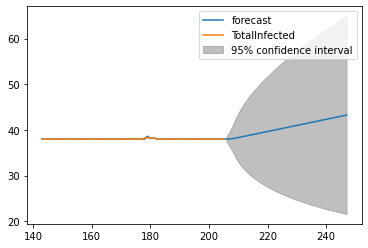

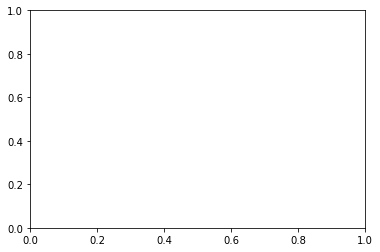

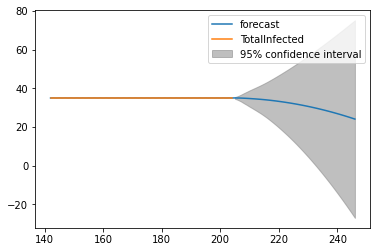

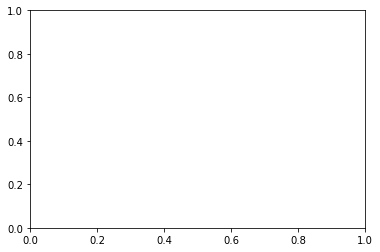

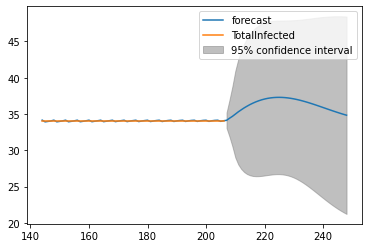

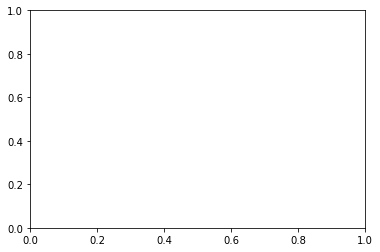

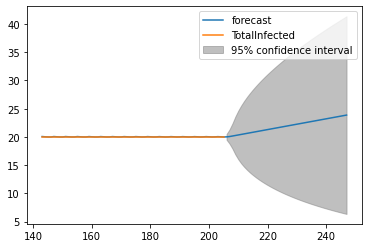

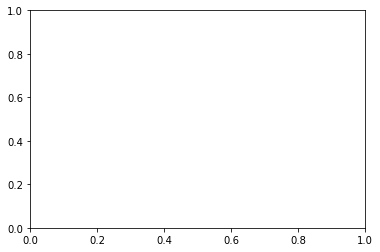

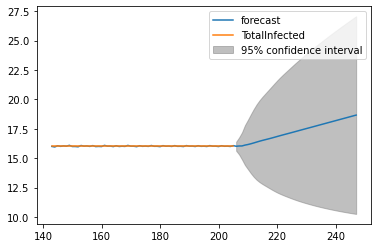

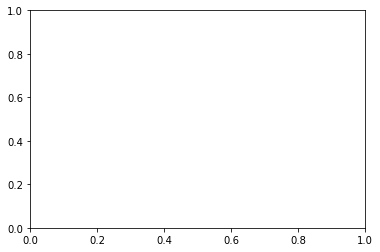

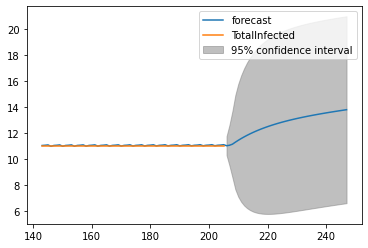

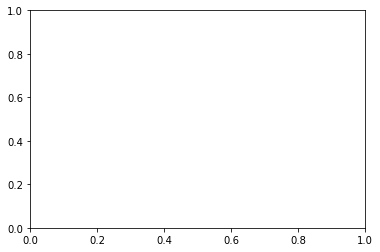

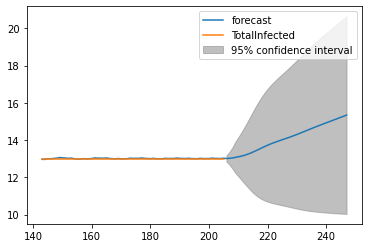

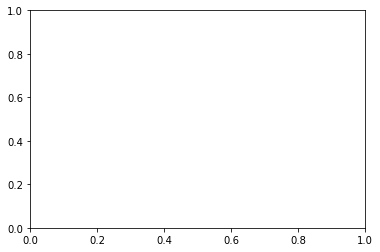

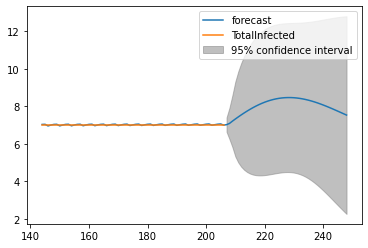

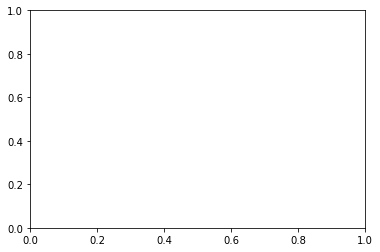

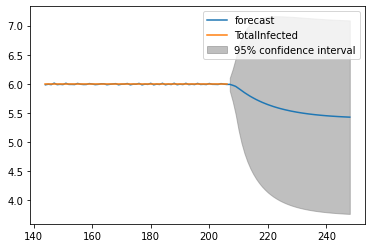

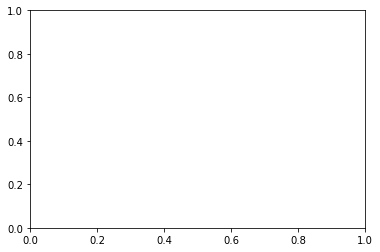

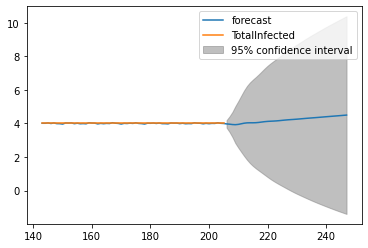

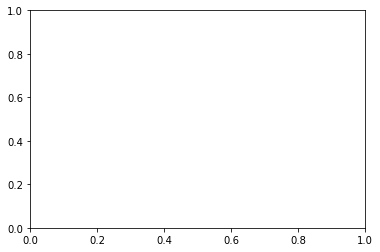

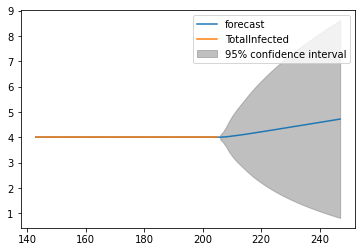

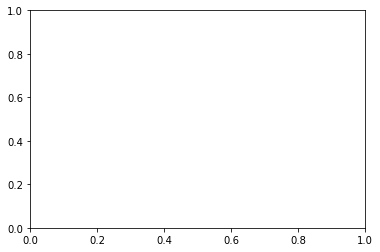

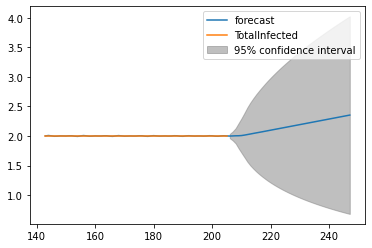

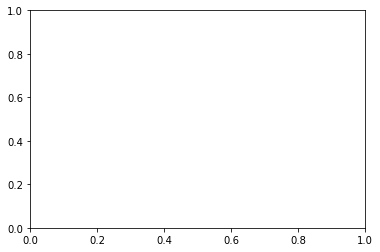

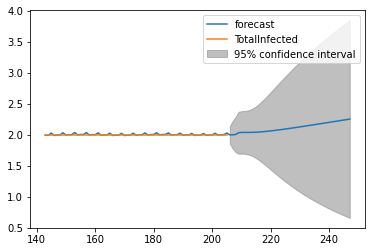

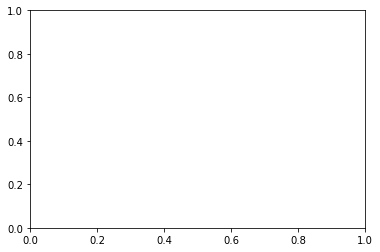

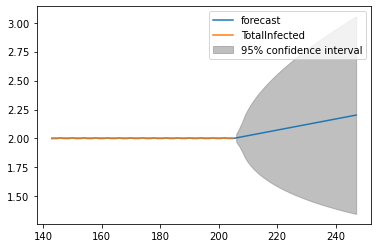

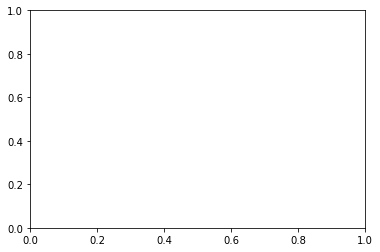

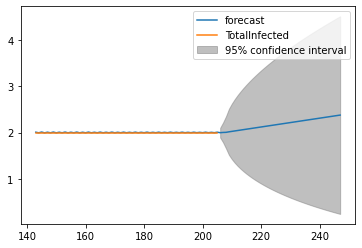

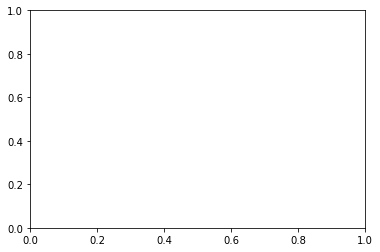

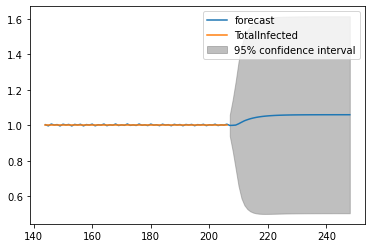

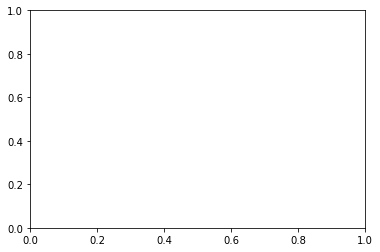

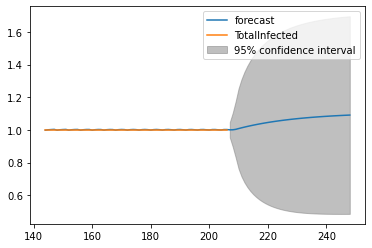

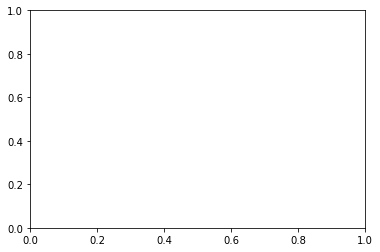

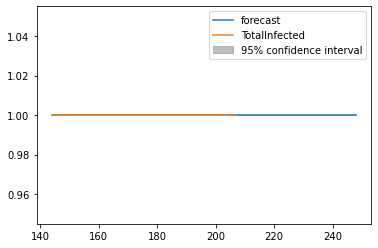

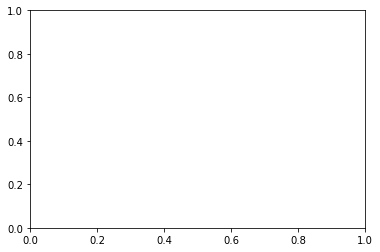

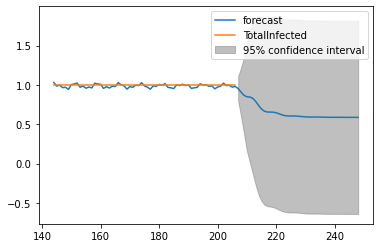

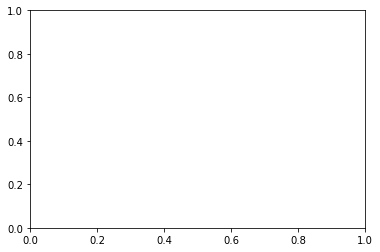

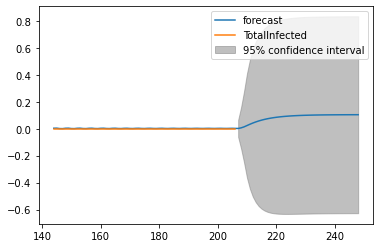

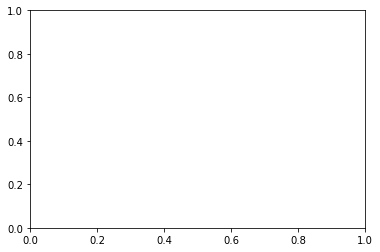

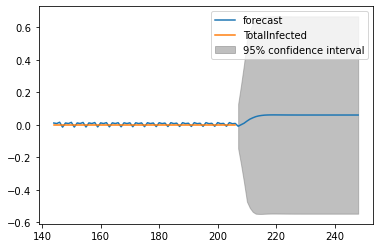

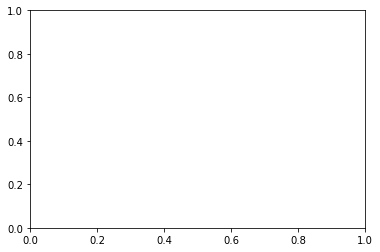

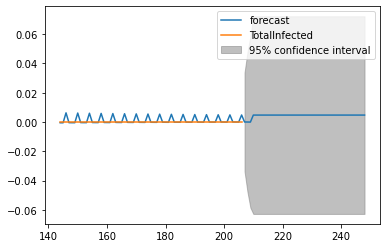

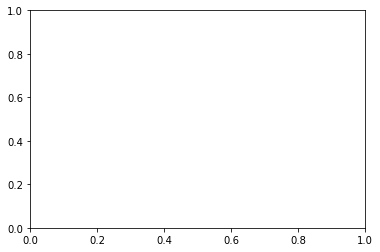

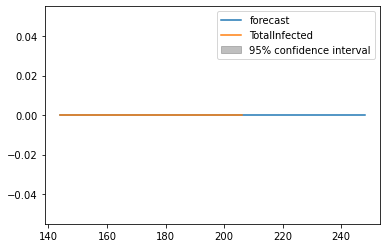

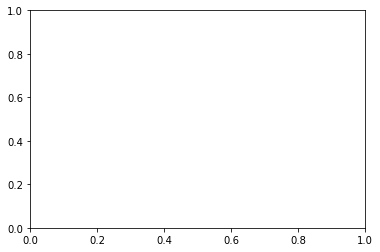

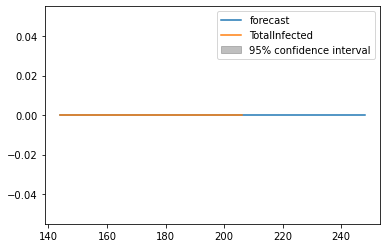

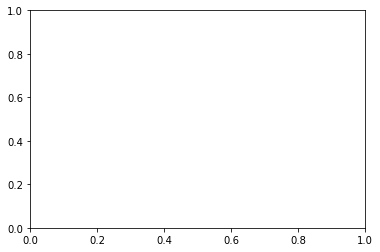

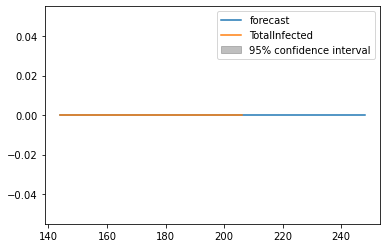

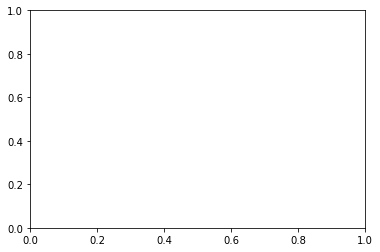

In [271]:
arima_test = Arima(train_df)
res_1 = arima_test.train()

In [272]:
rfr = RFRWalkingForward()
rfr.train(train_df)
res_2 = rfr.predict(test_df)

Mean RMSE = 7.33898


In [277]:
print(res_2)

[37.82725368 36.46805991 44.52571338 19.98       15.99868421 11.
 12.99772727  7.00803571  6.0225      4.          4.01875     1.99227564
  1.99448718  1.99833333  2.          1.03409091  1.          1.
  1.          0.22666542  0.16446158  0.14732143  0.          0.12946429
  0.14732143]


In [286]:
# ls_1 = list(res_1)
# ls_2 = list(res_2)
# lis_3 = [(ls_1[i]+ls_2[i])/2 for i in range(25)]
# fig = plt.figure()
# ax = fig.add_axes(lis_3)
# langs = ['Colombo','Gampaha','Kaluthara','Galle','Mathara',
#          'Hambanthota','Rathnapura','Kegalle','Kandy',
#          'NuwaraEliya','Matale','Badulla','Monaragale',
#          'Batticoloa','Ampara','Trincomalee','Puttalama',
#          'Anuradhapura','Polonnaruva','Jaffna','Killinochchi',
#          'Mannar','Mullathiv']
# students = [23,17,35,29,12]
# ax.bar(langs,students)
# plt.show()
print('hello')

hello


In [285]:
# print()
